In [ ]:
# --- imports & DB connection (reads creds from .env) ---
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()  # expects PG_HOST, PG_PORT, PG_DB, PG_USER, PG_PASSWORD in .env

engine = create_engine(
    f"postgresql+psycopg2://{os.getenv('PG_USER')}:{os.getenv('PG_PASSWORD')}"
    f"@{os.getenv('PG_HOST')}:{os.getenv('PG_PORT')}/{os.getenv('PG_DB')}"
)

print("Connected ✅")

Matplotlib is building the font cache; this may take a moment.


Connected ✅


In [ ]:
# --- sanity checks: counts ---
counts_sql = """
SELECT 'books' AS t, COUNT(*) FROM dwh.books
UNION ALL
SELECT 'fact_rating' AS t, COUNT(*) FROM dwh.fact_rating;
"""
pd.read_sql(counts_sql, engine)

,t,count
0,books,10000
1,fact_rating,979478


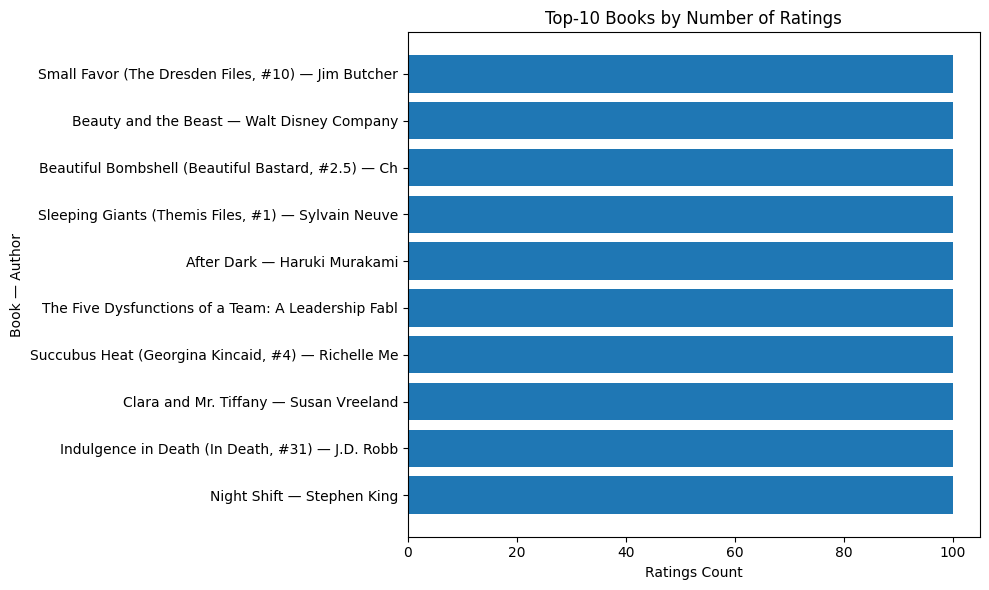

,book_id,source_book_id,title,authors,ratings_count,avg_rating
0,927979,1450,"Small Favor (The Dresden Files, #10)",Jim Butcher,100,4.32
1,1603923,5718,Beauty and the Beast,"Walt Disney Company, Ellen Titlebaum",100,4.44
2,17831617,7061,"Beautiful Bombshell (Beautiful Bastard, #2.5)",Christina Lauren,100,4.12
3,25733990,5921,"Sleeping Giants (Themis Files, #1)",Sylvain Neuvel,100,3.80
4,17803,1282,After Dark,"Haruki Murakami, Jay Rubin",100,3.56
5,21343,2327,The Five Dysfunctions of a Team: A Leadership ...,Patrick Lencioni,100,3.90
6,5148720,7780,"Succubus Heat (Georgina Kincaid, #4)",Richelle Mead,100,4.13
7,8296140,5104,Clara and Mr. Tiffany,Susan Vreeland,100,3.49
8,7685763,7328,"Indulgence in Death (In Death, #31)",J.D. Robb,100,4.15
9,10628,865,Night Shift,"Stephen King, John D. MacDonald",100,3.77


In [ ]:
# --- Top-10 Books by number of ratings ---
sql_top_books = """
SELECT 
  b.book_id,
  b.source_book_id,
  b.title,
  b.authors,
  COUNT(fr.rating)        AS ratings_count,
  ROUND(AVG(fr.rating),2) AS avg_rating
FROM dwh.fact_rating fr
JOIN dwh.books b
  ON b.source_book_id = fr.book_id
GROUP BY b.book_id, b.source_book_id, b.title, b.authors
ORDER BY ratings_count DESC
LIMIT 10;
"""
df_books = pd.read_sql(sql_top_books, engine)

# Plot with matplotlib (no seaborn, one chart per cell)
plt.figure(figsize=(10, 6))
# shorten long titles for readability
labels = (df_books["title"] + " — " + df_books["authors"].str.split(",").str[0]).str.slice(0, 50)
plt.barh(labels.iloc[::-1], df_books["ratings_count"].iloc[::-1])
plt.title("Top-10 Books by Number of Ratings")
plt.xlabel("Ratings Count")
plt.ylabel("Book — Author")
plt.tight_layout()
plt.show()

df_books  # to also see the table under the chart

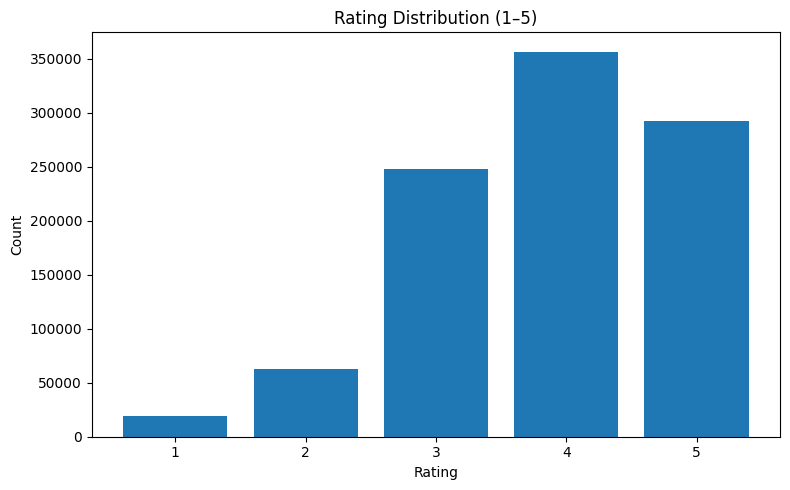

,rating,ratings_count
0,1,19513
1,2,63087
2,3,248076
3,4,356585
4,5,292217


In [ ]:
# --- Rating Distribution 1..5 ---
sql_dist = """
SELECT fr.rating, COUNT(*) AS ratings_count
FROM dwh.fact_rating fr
GROUP BY fr.rating
ORDER BY fr.rating;
"""
df_dist = pd.read_sql(sql_dist, engine)

plt.figure(figsize=(8, 5))
plt.bar(df_dist["rating"].astype(str), df_dist["ratings_count"])
plt.title("Rating Distribution (1–5)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

df_dist

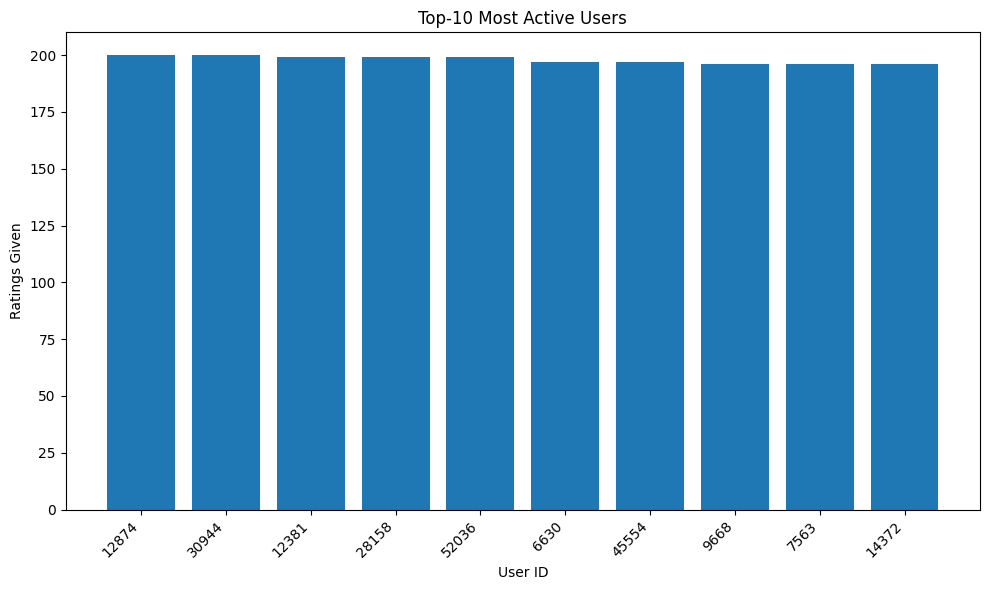

,user_id,ratings_given,avg_rating_given
0,12874,200,3.45
1,30944,200,4.21
2,12381,199,3.43
3,28158,199,3.94
4,52036,199,3.44
5,6630,197,3.57
6,45554,197,4.03
7,9668,196,3.84
8,7563,196,3.50
9,14372,196,3.60


In [ ]:
# --- Top-10 Most Active Users (Dot Plot) ---
sql_top_users = """
SELECT
    fr.user_id,
    COUNT(*) AS ratings_given,
    ROUND(AVG(fr.rating), 2) AS avg_rating_given
FROM dwh.fact_rating fr
GROUP BY fr.user_id
ORDER BY ratings_given DESC
LIMIT 10;
"""

df_users = pd.read_sql(sql_top_users, engine)

xs = df_users["user_id"].astype(str)          # X-axis: user IDs
ys = df_users["ratings_given"]                # Y-axis: number of ratings

plt.figure(figsize=(9, 5))
plt.scatter(xs, ys, s=60, color="blue")       # Dot plot
plt.ylim(190, ys.max() + 5)                   
plt.grid(axis='y', linestyle='--', alpha=.3)  
plt.title("Top-10 Most Active Users (Dot Plot)")
plt.xlabel("User ID")
plt.ylabel("Ratings Given")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df_users

In [ ]:
# Save last figure (repeat per chart as needed)
out_dir = "notebooks/exports"
os.makedirs(out_dir, exist_ok=True)
plt.gcf().savefig(os.path.join(out_dir, "top10_books.png"), dpi=200)

<Figure size 640x480 with 0 Axes>